In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [4]:
df = pd.read_csv("../data/freelancer_earnings_bd_cleaned.csv")


In [5]:
features = ['job_completed', 'earnings_usd', 'hourly_rate', 'job_success_rate',
            'client_rating', 'job_duration_days', 'rehire_rate', 'marketing_spend']

X = df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to DataFrame and show the result
X_scaled_df = pd.DataFrame(X_scaled, columns=features)
print(X_scaled_df.head())  # Shows the first few rows


   job_completed  earnings_usd  hourly_rate  job_success_rate  client_rating  \
0       0.340935     -1.161351     1.605094         -0.425804      -1.416902   
1       0.785593      1.387931     1.255549          1.545865      -0.965379   
2      -1.449401     -0.534114     1.210602          0.797164       0.354459   
3      -1.566416      0.191225    -1.419347          0.340690       0.823349   
4       1.101535      0.300948     1.738077         -1.173820       1.743763   

   job_duration_days  rehire_rate  marketing_spend  
0          -1.679892    -0.216305        -1.320648  
1           0.357290    -0.397595         1.604107  
2           0.049791     1.460874         1.624371  
3          -0.142396    -0.840913        -1.226083  
4          -0.142396     1.215191         1.624371  


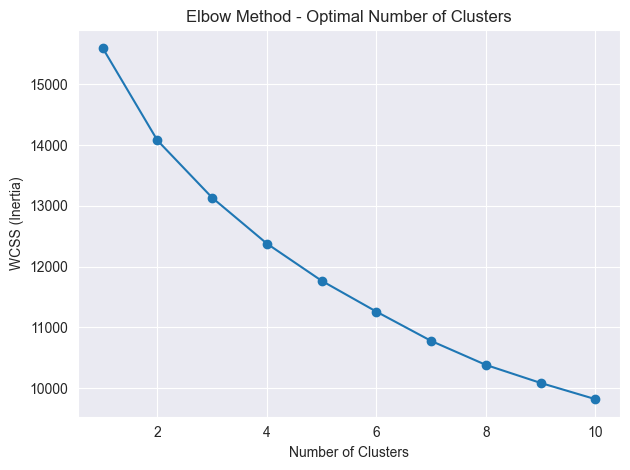

In [6]:
wcss = []
for k in range(1, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    wcss.append(km.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.title("Elbow Method - Optimal Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS (Inertia)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)


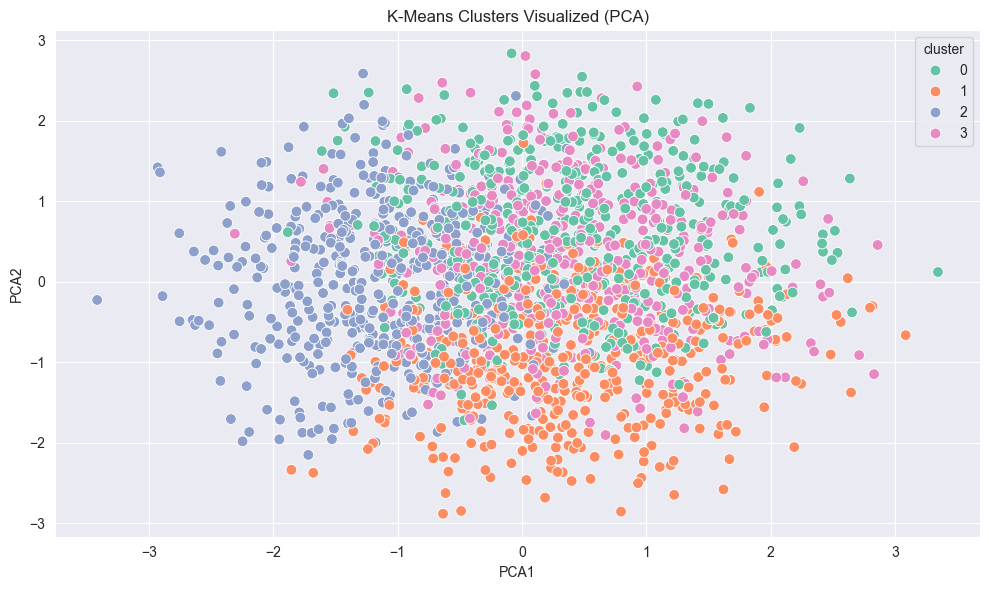

In [8]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df['PCA1'] = X_pca[:, 0]   # First principal component (x-axis)
df['PCA2'] = X_pca[:, 1]   # Second principal component (y-axis)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='cluster', palette='Set2', s=60)
plt.title("K-Means Clusters Visualized (PCA)")
plt.tight_layout()
plt.show()


In [ ]:
### K-Means Clusters Visualized Using PCA

# To better understand the distribution of the four clusters created by the K-Means algorithm, we applied PCA (Principal Component Analysis) to reduce the dataset to two dimensions.
# 
# Each point in the scatter plot represents a freelancer, and the colors indicate the cluster assignments. While there's some overlap, we can observe that the algorithm has captured distinct groups based on freelancer behavior and performance metrics.
# 
# This visualization helps confirm that four clusters (as chosen by the Elbow Method) provide a meaningful segmentation of the dataset.

In [6]:
df.groupby('cluster')[features].mean()  #For each cluster, what’s the average value of each feature?


,job_completed,earnings_usd,hourly_rate,job_success_rate,client_rating,job_duration_days,rehire_rate,marketing_spend
cluster,,,,,,,,
0,143.652008,5281.252390,55.054990,71.833920,4.469541,32.181644,47.615067,353.627151
1,146.702586,3992.592672,53.556509,74.237909,3.594375,27.060345,53.757112,149.407328
2,153.967054,5147.742248,47.036550,79.004070,4.296415,58.467054,34.059399,130.377907
3,160.040268,5622.733781,55.068725,74.663244,3.511588,61.785235,43.546644,364.791946


In [ ]:
# Cluster 1 –  Mid-level hustlers
# Medium job completion and earnings.
# Balanced performance and marketing spend.
# Good rehire rate and effort in visibility.
# 
# Cluster 2 –  Reliable professionals
# Highest job success rate (79%) and client rating (4.3).
# Lower hourly rate — might be more cost-effective or competitive.
# Decent earnings and longer job durations.
# Low rehire rate suggests one-time project focus.
# 
# Cluster 3 –  High earners, high marketers
# Highest earnings and hourly rate.
# Invests the most in marketing (364.79).
# Surprisingly low client rating (3.51), possibly due to higher expectations or difficult clients.
# Long job durations, likely complex or high-value work.


Distance threshold for outliers: 3.20
Total outliers detected: 98 out of 1950 freelancers


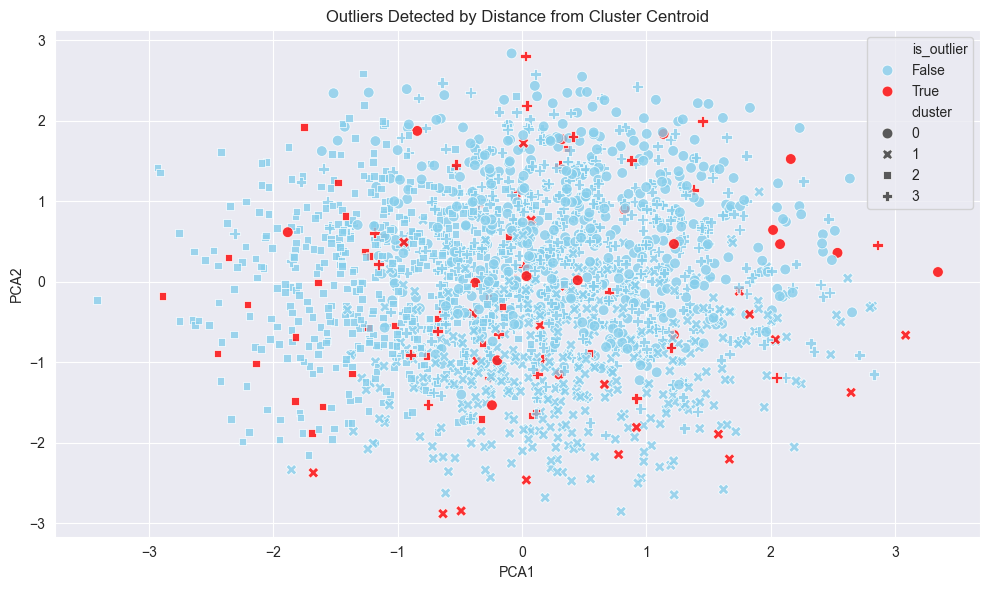

In [9]:
from sklearn.metrics import pairwise_distances_argmin_min
import numpy as np

# Compute distances to assigned centroids
_, distances = pairwise_distances_argmin_min(X_scaled, kmeans.cluster_centers_)

# Add distances to DataFrame
df['distance_to_centroid'] = distances

# Flag top 5% as potential outliers
threshold = np.percentile(distances, 95)
df['is_outlier'] = df['distance_to_centroid'] > threshold

print(f"Distance threshold for outliers: {threshold:.2f}")
print(f"Total outliers detected: {df['is_outlier'].sum()} out of {len(df)} freelancers")

# Visualize outliers in PCA space
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='PCA1',
    y='PCA2',
    hue='is_outlier',
    style='cluster',
    palette={False: 'skyblue', True: 'red'},
    s=60,
    alpha=0.8
)
plt.title("Outliers Detected by Distance from Cluster Centroid")
plt.tight_layout()
plt.show()

# Summary
# We calculated each freelancer’s distance to their cluster’s centroid.
# Those in the top 5% of distances were marked as outliers — meaning they behave quite differently from their cluster group.
# These could be exceptionally high or low earners, unusually rated freelancers, or edge cases worth investigating further.


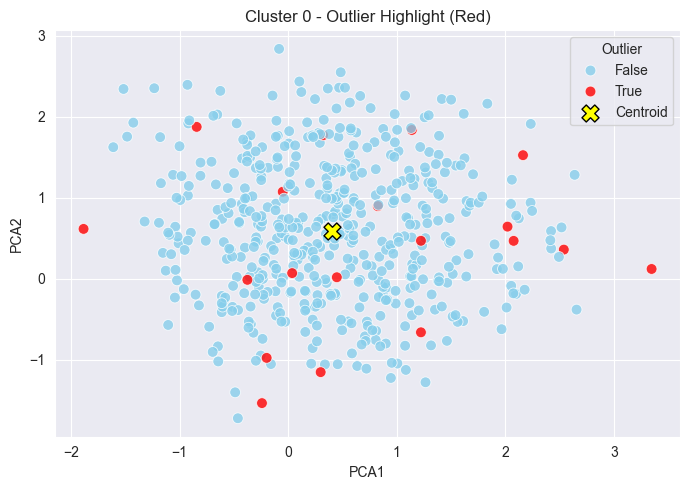

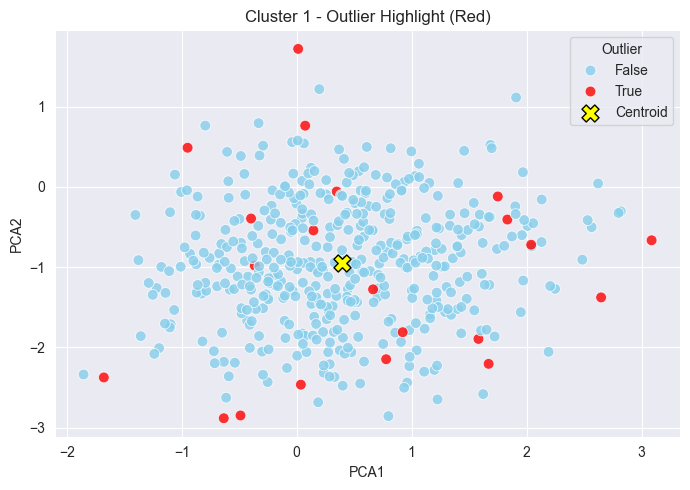

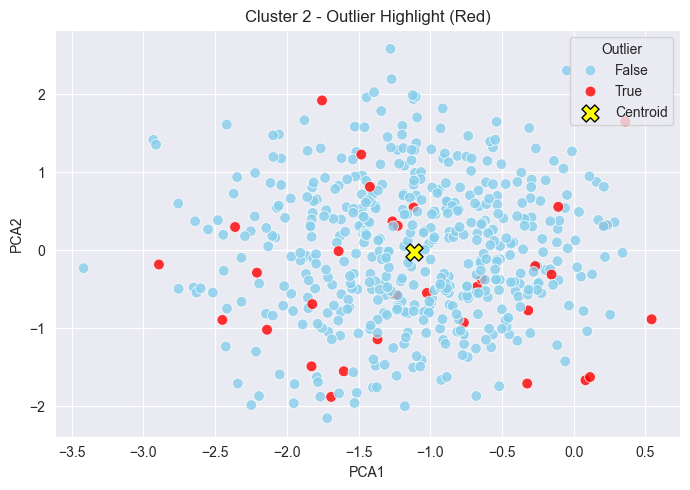

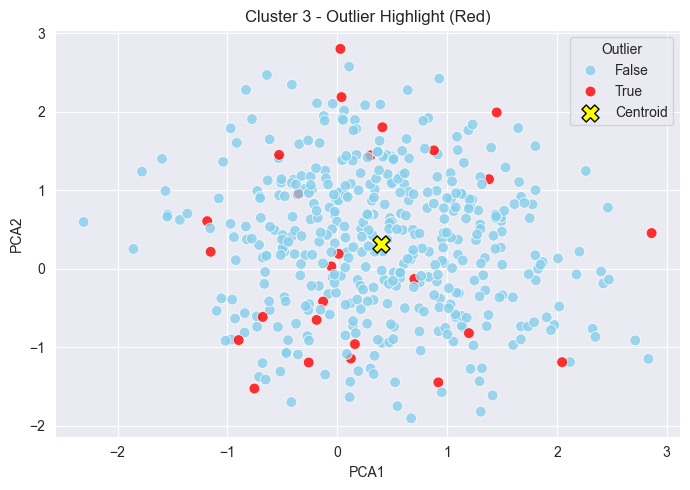

In [10]:
import matplotlib.pyplot as plt

# Transform the cluster centroids into PCA space
centroids_pca = PCA(n_components=2).fit(X_scaled).transform(kmeans.cluster_centers_)

clusters = df['cluster'].unique()
palette = {False: 'skyblue', True: 'red'}

for cluster_id in sorted(clusters):
    plt.figure(figsize=(7, 5))

    cluster_data = df[df['cluster'] == cluster_id]

    sns.scatterplot(
        data=cluster_data,
        x='PCA1',
        y='PCA2',
        hue='is_outlier',
        palette=palette,
        s=60,
        alpha=0.8
    )

    # Plot centroid for this cluster
    plt.scatter(
        centroids_pca[cluster_id, 0],
        centroids_pca[cluster_id, 1],
        marker='X',
        s=150,
        color='yellow',
        edgecolor='black',
        label='Centroid'
    )

    plt.title(f"Cluster {cluster_id} - Outlier Highlight (Red)")
    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.legend(title="Outlier", loc='upper right')
    plt.tight_layout()
    plt.show()


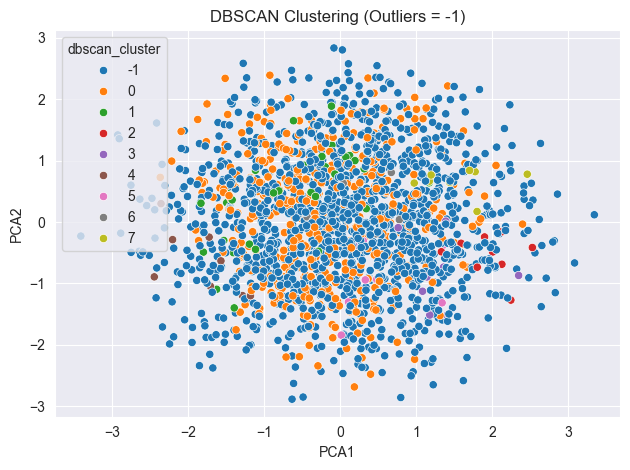

In [11]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1.5, min_samples=10)
df['dbscan_cluster'] = dbscan.fit_predict(X_scaled)

# -1 are the outliers in DBSCAN
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='dbscan_cluster', palette='tab10')
plt.title("DBSCAN Clustering (Outliers = -1)")
plt.tight_layout()
plt.show()


In [12]:
df['kmeans_outlier'] = df['is_outlier']
df['dbscan_outlier'] = df['dbscan_cluster'] == -1

overlap = df[(df['kmeans_outlier']) & (df['dbscan_outlier'])]
print(f"Outliers detected by both: {len(overlap)}")


Outliers detected by both: 94


In [ ]:
### Outlier Agreement Between Methods
# 
# To validate our K-Means-based outlier detection, we also applied DBSCAN — a density-based clustering algorithm that flags outliers as noise points.
# 
# Out of the dataset, **94 freelancers** were identified as outliers by **both K-Means and DBSCAN**. This strong overlap suggests that these individuals are indeed **high-confidence anomalies**, reinforcing the reliability of our outlier detection approach.
